In [1]:
import sys
parentdir = 'C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT'
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from graph.precision_recall import precision_recall
from tqdm import tqdm
import time
plt.rcParams.update({'font.size': 22})

In [3]:
def get_n_nearest(data, columns, corr = False, number_close=5):
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups

In [5]:
df = pd.read_csv('C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT-old\\data\\pigs.csv')
df

,p630400490,p48124091,p627270088,p392115290,p627276488,p392150190,p48109691,p630071089,p630067789,p630384190,...,p82154888,p82071386,p750261487,p82140988,p627350790,p627257588,p627333990,p82155088,p627253288,p82265990
0,1,1,1,1,0,1,0,1,1,1,...,1,1,0,0,1,2,1,1,1,0
1,1,1,1,2,0,1,1,2,2,2,...,1,1,1,0,1,2,2,1,2,2
2,0,1,0,0,1,2,1,0,1,0,...,1,0,2,1,1,1,0,2,1,2
3,0,1,1,1,1,1,2,2,2,2,...,1,2,1,2,1,1,0,1,1,2
4,0,1,2,2,0,1,1,0,1,0,...,2,1,2,1,2,1,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2,2,2,1,1,1,2,1,2,...,2,1,2,2,2,2,2,1,2,2
9996,2,1,2,2,1,2,1,0,0,0,...,2,1,1,1,2,1,0,1,1,0
9997,2,2,2,2,0,1,2,2,1,2,...,1,2,1,2,1,1,1,2,1,1
9998,1,1,1,0,2,1,0,1,1,0,...,1,2,0,1,1,1,0,0,0,0


In [6]:
df_coded, coder = code_categories(df, 'label', df.columns)
df_coded

,p630400490,p48124091,p627270088,p392115290,p627276488,p392150190,p48109691,p630071089,p630067789,p630384190,...,p82154888,p82071386,p750261487,p82140988,p627350790,p627257588,p627333990,p82155088,p627253288,p82265990
0,1,1,1,1,0,1,0,1,1,1,...,1,1,0,0,1,2,1,1,1,0
1,1,1,1,2,0,1,1,2,2,2,...,1,1,1,0,1,2,2,1,2,2
2,0,1,0,0,1,2,1,0,1,0,...,1,0,2,1,1,1,0,2,1,2
3,0,1,1,1,1,1,2,2,2,2,...,1,2,1,2,1,1,0,1,1,2
4,0,1,2,2,0,1,1,0,1,0,...,2,1,2,1,2,1,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2,2,2,1,1,1,2,1,2,...,2,1,2,2,2,2,2,1,2,2
9996,2,1,2,2,1,2,1,0,0,0,...,2,1,1,1,2,1,0,1,1,0
9997,2,2,2,2,0,1,2,2,1,2,...,1,2,1,2,1,1,1,2,1,1
9998,1,1,1,0,2,1,0,1,1,0,...,1,2,0,1,1,1,0,0,0,0


In [8]:
structure = pd.read_csv('C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT-old\\data\\pigs_true.csv')
print(structure)
structure_right = []
for i in structure.index:
    structure_right.append([structure.loc[i,'V1'], structure.loc[i,'V2']])

             V1          V2
0    p630400490   p48124091
1    p627270088  p392115290
2    p627276488  p392150190
3    p630071089  p630384190
4    p630067789  p630384190
..          ...         ...
587  p627253288  p392150190
588  p627253288  p627320490
589  p627253288  p627333990
590  p627253288   p82265990
591   p82265990   p48124091

[592 rows x 2 columns]


In [9]:
sparsebn_edges = pd.read_csv('C:\\Users\\Jerzy\\Documents\\GitHub\\BAMT-old\\data\\pigs_sparsebn.csv')
sparsebn_edges

,V1,V2
0,p630400490,p48124091
1,p48124091,p82265990
2,p627270088,p392115290
3,p392115290,p627253288
4,p392150190,p627276488
...,...,...
707,p627333990,p627253288
708,p627253288,p392150190
709,p627253288,p627320490
710,p627253288,p82265990


In [11]:
pr = precision_recall(sparsebn_edges, structure_right)
pr

{'AP': 0.0, 'AR': 0.0, 'AHP': 0.0, 'AHR': 0.0, 'SHD': 1304}

<AxesSubplot:>

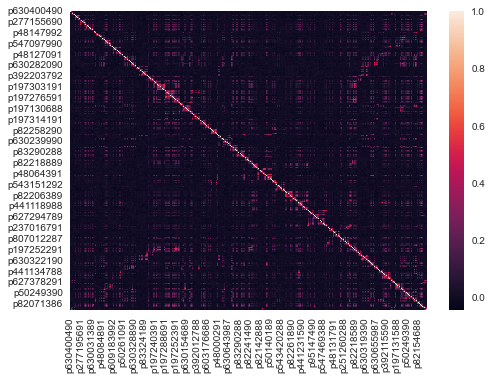

In [12]:
corr = df_coded.corr(method='spearman')
sns.heatmap(corr)

100%|██████████| 7/7 [1:01:12<00:00, 524.64s/it]


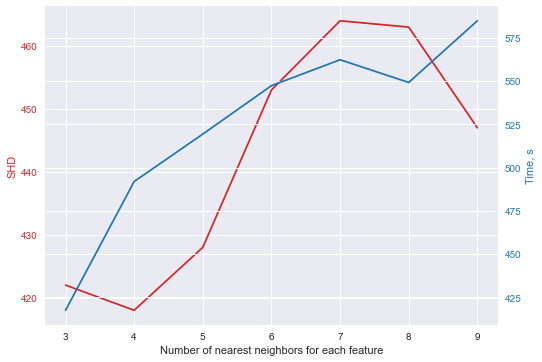

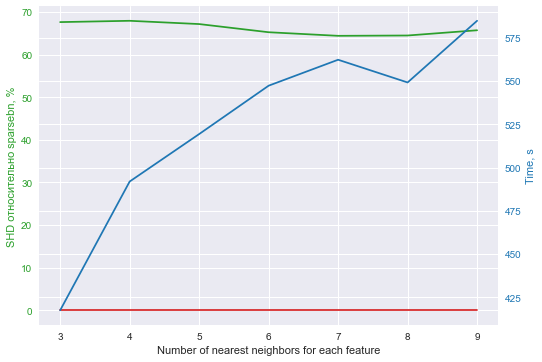

In [13]:
shd_different_n_nearest = []
time_n_nearest = []
range_of_n_nearest = np.arange(3, 10)
brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns
for i in tqdm(range_of_n_nearest):
    start_time = time.time()
    groups = get_n_nearest(corr, df.columns.tolist(), corr=True, number_close= i)
    for c1 in df.columns:
        for c2 in df.columns:
            a = 0
            b = 0
            c = 0
            d = 0
            if c1 != c2:
                for g in groups:
                    if (c1 in g) & (c2 in g):
                        a += 1
                    if (c1 in g) & (c2 not in g):
                        b += 1
                    if (c1 not in g) & (c2 in g):
                        c += 1
                    if (c1 not in g) & (c2 not in g):
                        d += 1
                br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
                brave.loc[c1,c2] = br
    possible_edges = []
    for c1 in df.columns:
        for c2 in df.columns:
            if brave.loc[c1, c2] > brave.max(numeric_only='true').max()*0.5:
                possible_edges.append((c1, c2))
    bn = structure_learning(df_coded, 'HC', get_nodes_type(df_coded), 'K2', white_list=possible_edges)
    brave_edgse = []
    for e in bn['E']:
        brave_edgse.append((e[0], e[1]))
    shd_different_n_nearest.append(precision_recall(brave_edgse, structure_right)['SHD'])
    time_n_nearest.append(time.time() - start_time)
shd_different_n_nearest

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Number of nearest neighbors for each feature')
ax1.set_ylabel('SHD', color=color)
ax1.plot(range_of_n_nearest, shd_different_n_nearest, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time, s', color=color)  
ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

shd_results_n_relative = (1 - np.asarray(shd_different_n_nearest)/pr['SHD']) * 100
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.set_xlabel('Number of nearest neighbors for each feature')
ax1.set_ylabel('SHD относительно sparsebn, %', color=color)
ax1.plot(range_of_n_nearest, shd_results_n_relative, color=color)
ax1.plot(range_of_n_nearest, 0*shd_results_n_relative, color='tab:red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time, s', color=color)  
ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()


<AxesSubplot:>

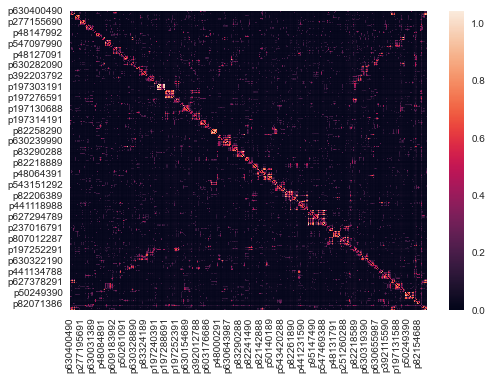

In [14]:
sns.heatmap(brave)

100%|██████████| 11/11 [39:38<00:00, 216.22s/it] 


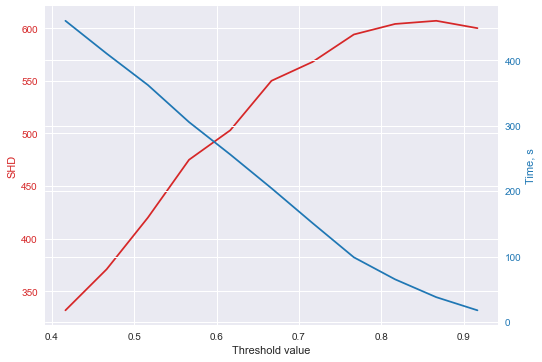

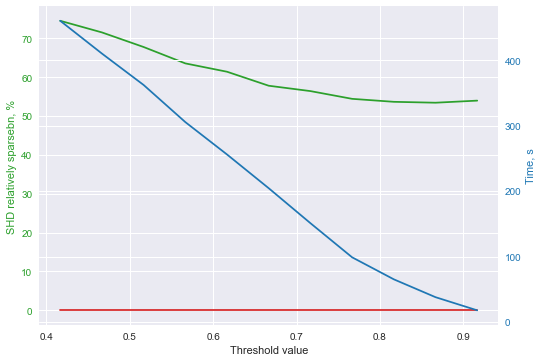

In [15]:
shd_results = []
range_of_experiment = []
time_not_norm = []

brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns
groups = get_n_nearest(corr, df.columns.tolist(), corr=True, number_close = 5)
for c1 in df.columns:
    for c2 in df.columns:
        a = 0
        b = 0
        c = 0
        d = 0
        if c1 != c2:
            for g in groups:
                if (c1 in g) & (c2 in g):
                    a += 1
                if (c1 in g) & (c2 not in g):
                    b += 1
                if (c1 not in g) & (c2 in g):
                    c += 1
                if (c1 not in g) & (c2 not in g):
                    d += 1
            br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
            brave.loc[c1,c2] = br

range_of_experiment = np.arange(brave.max(numeric_only='true').max()*0.4, brave.max(numeric_only='true').max()*0.9, 0.05)
for n in tqdm(range_of_experiment):
    possible_edges = []
    for c1 in df.columns:
        for c2 in df.columns:
            if brave.loc[c1, c2] > n:
                possible_edges.append((c1, c2))
    start_time = time.time()
    bn = structure_learning(df_coded, 'HC', get_nodes_type(df_coded), 'K2', white_list=possible_edges)
    time_not_norm.append(time.time() - start_time)
    brave_edgse = []
    for e in bn['E']:
        brave_edgse.append((e[0], e[1]))
    shd_results.append(precision_recall(brave_edgse, structure_right)['SHD'])
shd_results

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('SHD', color=color)
ax1.plot(range_of_experiment, shd_results, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time, s', color=color)  
ax2.plot(range_of_experiment, time_not_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

shd_results_relative = (1 - np.asarray(shd_results)/pr['SHD']) * 100
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('SHD relatively sparsebn, %', color=color)
ax1.plot(range_of_experiment, shd_results_relative, color=color)
ax1.plot(range_of_experiment, shd_results_relative*0, color='tab:red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time, s', color=color)  
ax2.plot(range_of_experiment, time_not_norm, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1

fig.tight_layout() 
plt.show()